In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import datetime
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

2023-06-26 12:21:19.309684: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
    )
  except RuntimeError as e:
    print(e)

devices = tf.config.list_physical_devices()
print("Available devices:\n", devices)
gpus = tf.config.list_physical_devices("GPU")
tf.config.set_visible_devices(gpus[0], "GPU")
logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print("Using GPU:", logical_gpus[0].name)

Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: /device:GPU:0


In [4]:
data = pd.read_csv('./data/train_data_subsampled_isolate1.csv')

y = data['R']
X = data.drop(['R'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_test.shape)
print(X_train.shape)

(257, 4)
(1025, 4)


In [23]:
model = keras.Sequential([
    keras.layers.Dense(4, activation='tanh', input_shape=(4,), kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(2, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dense(1)
])


# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.005, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model
epochs = 150  # Number of training iterations
batch_size = 32 # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)

#Create a TensorBoard callback
!rm -rf ./logs/ # Clear any logs from previous runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode="min", restore_best_weights=True)

#Create a csv logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log')

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler, tensorboard_callback, early_stopping_callback, csv_logger]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.2)
#history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[tensorboard_callback], validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 1s 5ms/step - loss: 0.0074 - mae: 0.0665 - val_loss: 0.0012 - val_mae: 0.0303 - lr: 0.0050
Epoch 2/150
26/26 [==============================] - 0s 3ms/step - loss: 0.0016 - mae: 0.0321 - val_loss: 5.8254e-04 - val_mae: 0.0187 - lr: 0.0050
Epoch 3/150
26/26 [==============================] - 0s 3ms/step - loss: 9.5523e-04 - mae: 0.0243 - val_loss: 5.2335e-04 - val_mae: 0.0177 - lr: 0.0050
Epoch 4/150
26/26 [==============================] - 0s 3ms/step - loss: 7.8693e-04 - mae: 0.0214 - val_loss: 4.7536e-04 - val_mae: 0.0168 - lr: 0.0050
Epoch 5/150
26/26 [==============================] - 0s 3ms/step - loss: 6.2673e-04 - mae: 0.0196 - val_loss: 4.3978e-04 - val_mae: 0.0162 - lr: 0.0050
Epoch 6/150
26/26 [==============================] - 0s 3ms/step - loss: 5.3881e-04 - mae: 0.0178 - val_loss: 4.1017e-04 - val_mae: 0.0154 - lr: 0.0050
Epoch 7/150
26/26 [==============================] - 0s 3ms/step - loss: 4.7321e-04 - mae: 0.0164 - 

In [22]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)

# Make predictions using the trained model
predictions = model.predict(X_test)

9/9 [==============================] - 0s 846us/step - loss: 1.3258e-04 - mae: 0.0082


9/9 [==============================] - 0s 490us/step


In [9]:
%tensorboard --logdir /logs/fit

UsageError: Line magic function `%tensorboard` not found.


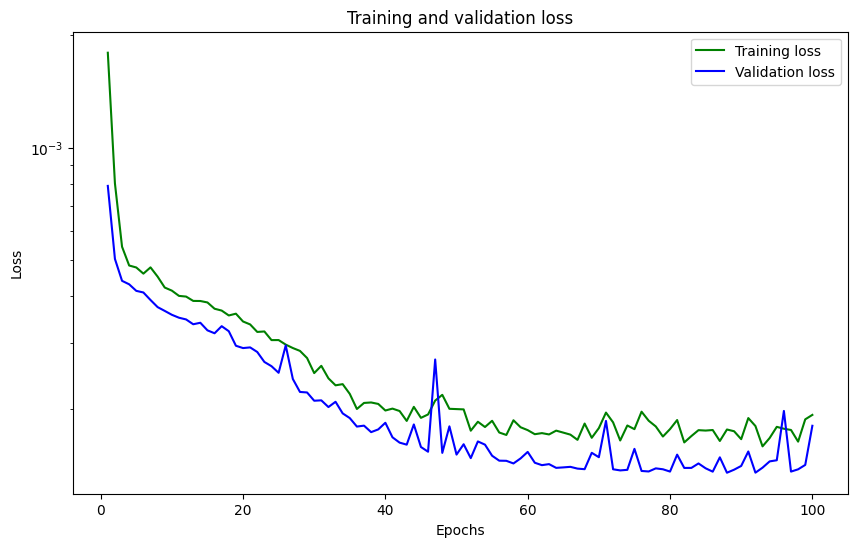

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.semilogy(epochs, loss, 'g', label='Training loss')
plt.semilogy(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#model.save('model.h5')


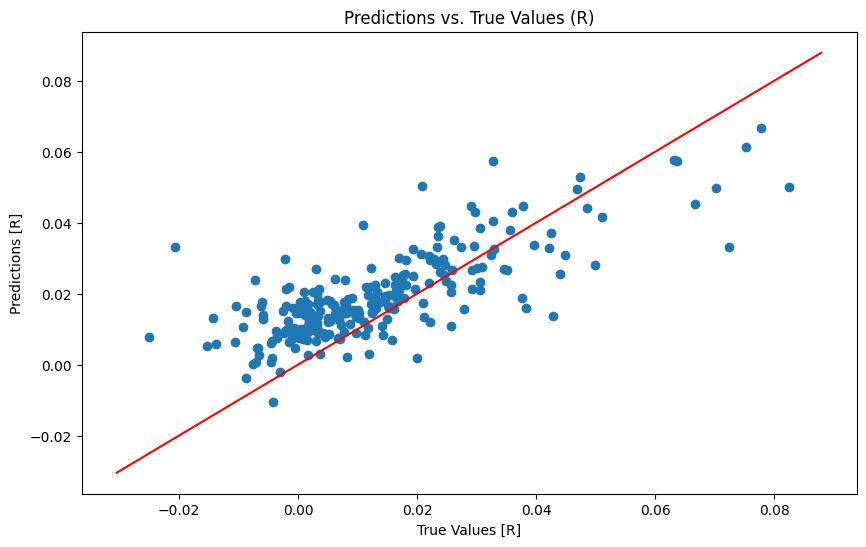

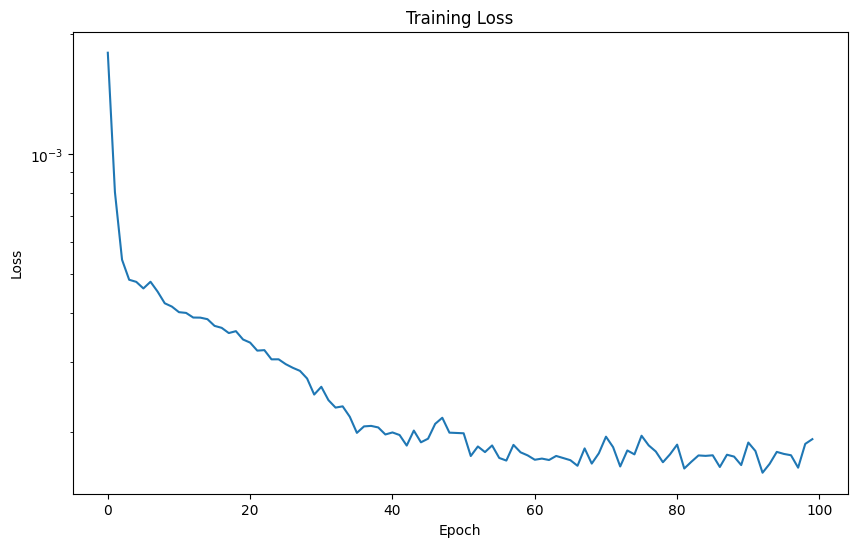

In [11]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(y_test).iloc[:,0], predictions)
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
#plt.axis('equal')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()